<a href="https://colab.research.google.com/github/daryashaporewa-netizen/wildlife/blob/main/wildlife_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Тема : "«Автоматическое обнаружение и подсчёт крупных диких животных (буйволов, слонов, носорогов и зебр) на фотографиях африканской саванны с использованием предобученной модели YOLO»"

## Задача

В этом ноутбуке я дообучаю готовую модель YOLOv8 для обнаружения и подсчёта крупных диких животных (буйволов, слонов, носорогов и зебр) на фотографиях африканской саванны.  
Цель — научить модель автоматически находить животных на снимках и оценивать их количество, чтобы такую систему можно было использовать для мониторинга популяций вместо ручного просмотра тысяч фотографий.  

Дальше в ноутбуке:  
1. Загружаю размеченный датасет через Kaggle API.  
2. Проверяю структуру данных и настраиваю YAML для YOLO.  
3. Обучаю модель, смотрю метрики качества.  
4. Оцениваю точность детекции и подсчёта животных на тестовом наборе.

In [31]:
# Ячека импорта
from __future__ import annotations
import json
import os
from pathlib import Path
from typing import List, Tuple
from typing import Any, Dict
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [32]:
# Данные для Kaggle API
KAGGLE_USERNAME = "KAGGLE_USERNAME"
KAGGLE_KEY = "KGAT_7"

# Устанавливаем kaggle
!pip install -q kaggle

# Создаём файл конфигурации kaggle.json
kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(parents=True, exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
kaggle_config = {"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}

with kaggle_json_path.open("w", encoding="utf-8") as f:
    json.dump(kaggle_config, f)

os.chmod(kaggle_json_path, 0o600)

print("Файл kaggle.json создан по пути:", kaggle_json_path)

# Скачиваем и распаковываем датасет
data_dir = Path("/content/wildlife_yolo")
data_dir.mkdir(parents=True, exist_ok=True)

!kaggle datasets download -d ankanghosh651/object-detection-wildlife-dataset-yolo-format -p "{data_dir}" --unzip

print("\nСодержимое директории с датасетом:")
for path in data_dir.iterdir():
    print("-", path.name)

Файл kaggle.json создан по пути: /root/.kaggle/kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ankanghosh651/object-detection-wildlife-dataset-yolo-format
License(s): MIT
 95% 428M/449M [00:09<00:00, 29.3MB/s]
100% 449M/449M [00:09<00:00, 47.8MB/s]

Содержимое директории с датасетом:
- final_data


В этой ячейке я настроила доступ к Kaggle через API (kaggle.json) и скачала датасет *Object Detection – Wildlife Dataset (YOLO format)* в рабочую директорию `/content/wildlife_yolo`.  
Этот датасет содержит размеченные изображения буйволов, слонов, носорогов и зебр и будет использоваться для обучения и тестирования модели детекции YOLO.

In [33]:
# Смотрим, что лежит внутри скачанного датасета
DATA_ROOT = Path("/content/wildlife_yolo/final_data")

def inspect_dataset(root):
    """Печатаем структуру датасета и примеры файлов."""
    if not root.exists():
        raise FileNotFoundError(f"Директория не найдена: {root}")

    print("Корневая директория датасета:", root.resolve())
    print("\nОбъекты верхнего уровня:")

    for item in sorted(root.iterdir()):
        kind = "DIR " if item.is_dir() else "FILE"
        print(f"- [{kind}] {item.name}")

    image_dirs = list(root.rglob("images"))
    label_dirs = list(root.rglob("labels"))

    print("\nНайденные папки с изображениями:")
    for d in image_dirs:
        print("-", d)

    print("\nНайденные папки с разметкой:")
    for d in label_dirs:
        print("-", d)

    if image_dirs:
        print("\nПримеры файлов изображений:")
        for img in sorted(image_dirs[0].glob("*"))[:5]:
            print("-", img.name)

    if label_dirs:
        print("\nПримеры файлов разметки (.txt):")
        for lbl in sorted(label_dirs[0].glob("*.txt"))[:5]:
            print("-", lbl.name)


inspect_dataset(DATA_ROOT)

Корневая директория датасета: /content/wildlife_yolo/final_data

Объекты верхнего уровня:
- [FILE] data_wl.yaml
- [FILE] data_wl_local.yaml
- [DIR ] test
- [DIR ] train
- [DIR ] valid

Найденные папки с изображениями:
- /content/wildlife_yolo/final_data/train/images
- /content/wildlife_yolo/final_data/valid/images
- /content/wildlife_yolo/final_data/test/images

Найденные папки с разметкой:
- /content/wildlife_yolo/final_data/train/labels
- /content/wildlife_yolo/final_data/valid/labels
- /content/wildlife_yolo/final_data/test/labels

Примеры файлов изображений:
- 0001.jpg
- 0002.jpg
- 0003.jpg
- 0004.jpg
- 0005.jpg

Примеры файлов разметки (.txt):
- 0001.txt
- 0002.txt
- 0003.txt
- 0004.txt
- 0005.txt


Во второй ячейке я проверила структуру скачанного датасета: посмотрела корневые папки, нашла директории `images` и `labels` и убедилась, что в них есть файлы с изображениями и разметкой.  
Это нужно, чтобы дальше правильно настроить путь к датасету в YAML-файле и без ошибок запустить обучение модели YOLO.

In [34]:
# Устанавливаем библиотеку ultralytics (YOLOv8)

!pip install -q ultralytics

# Быстрая проверка:
from ultralytics import YOLO

print("Ultralytics YOLO успешно импортирован.")

Ultralytics YOLO успешно импортирован.


In [35]:
# Правим пути в data_wl.yaml под нашу локальную структуру

data_root = Path("/content/wildlife_yolo/final_data")
src_yaml = data_root / "data_wl.yaml"
dst_yaml = data_root / "data_wl_local.yaml"

def fix_data_yaml(src_path, dst_path, root_path):
    """Переписываем пути train/val/test в YAML на локальные."""
    if not src_path.exists():
        raise FileNotFoundError(f"Файл не найден: {src_path}")

    with src_path.open("r", encoding="utf-8") as f:
        cfg = yaml.safe_load(f)

    cfg["path"] = str(root_path.resolve())
    cfg["train"] = "train/images"
    cfg["val"] = "valid/images"
    cfg["test"] = "test/images"

    with dst_path.open("w", encoding="utf-8") as f:
        yaml.safe_dump(cfg, f, sort_keys=False, allow_unicode=True)

    print("Новый YAML сохранён в:", dst_path.resolve())
    print("\nКлючевые поля:")
    for key in ["path", "train", "val", "test", "names"]:
        print(key, ":", cfg.get(key))

fix_data_yaml(src_yaml, dst_yaml, data_root)

Новый YAML сохранён в: /content/wildlife_yolo/final_data/data_wl_local.yaml

Ключевые поля:
path : /content/wildlife_yolo/final_data
train : train/images
val : valid/images
test : test/images
names : {0: 'buffalo', 1: 'elephant', 2: 'rhino', 3: 'zebra'}


In [36]:
# Обучаем YOLOv8n на локальном датасете wildlife с исправленным YAML

data_yaml_path = Path("/content/wildlife_yolo/final_data/data_wl_local.yaml")

# Загружаем маленькую предобученную модель
model = YOLO("yolov8n.pt")

# Запускаем обучение
results = model.train(
    data=str(data_yaml_path),          # наш YAML с путями и классами
    epochs=5,                          # количество эпох
    imgsz=640,                         # размер входного изображения
    batch=8,                           # размер батча
    device="cpu",                      # обучаем на CPU
    project="wildlife_yolo_project",   # папка проекта в runs/
    name="yolov8n_wildlife_v1",        # имя эксперимента
    exist_ok=True,                     # не ругаться, если папка уже есть
)

print("Обучение завершено.")
print("Результаты сохранены в:", Path(results.save_dir).resolve())

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/wildlife_yolo/final_data/data_wl_local.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_wildlife_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100


image 1/1 /content/wildlife_yolo/final_data/valid/images/0015.jpg: 448x640 1 buffalo, 217.7ms
Speed: 4.0ms preprocess, 217.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


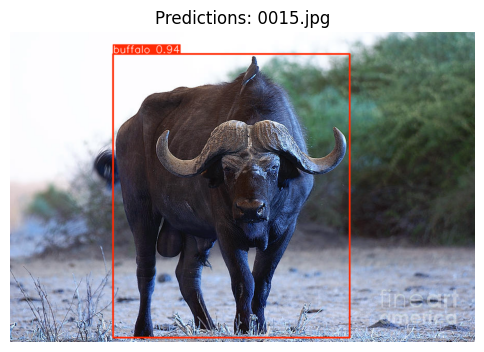


image 1/1 /content/wildlife_yolo/final_data/valid/images/0018.jpg: 448x640 1 buffalo, 263.1ms
Speed: 4.8ms preprocess, 263.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


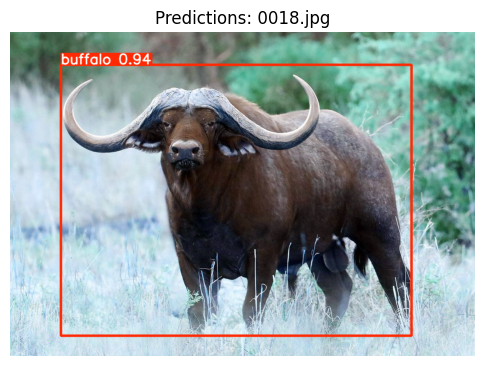


image 1/1 /content/wildlife_yolo/final_data/valid/images/0021.jpg: 512x640 1 buffalo, 460.0ms
Speed: 6.6ms preprocess, 460.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


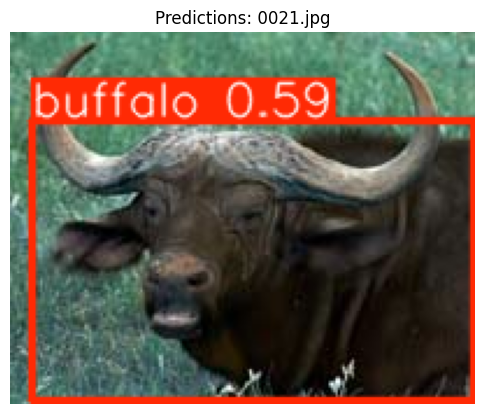


image 1/1 /content/wildlife_yolo/final_data/valid/images/0032.jpg: 640x512 1 buffalo, 701.0ms
Speed: 11.1ms preprocess, 701.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


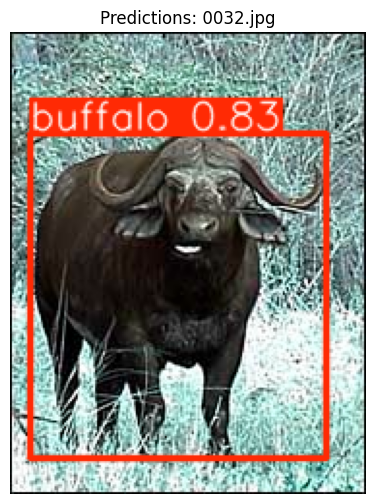

In [37]:
# Тестирование модели: смотрим предсказания на валидационных картинках
weights_path = Path(
    "/content/wildlife_yolo_project/yolov8n_wildlife_v1/weights/best.pt"
)
val_images_dir = Path("/content/wildlife_yolo/final_data/valid/images")

def show_sample_predictions(weights_path, images_dir, num_images=4):
    """Показываем несколько картинок с предсказаниями модели."""
    if not weights_path.exists():
        raise FileNotFoundError(f"Файл весов не найден: {weights_path}")
    if not images_dir.exists():
        raise FileNotFoundError(f"Папка с изображениями не найдена: {images_dir}")

    model = YOLO(str(weights_path))
    image_paths = sorted(images_dir.glob("*.jpg"))[:num_images]

    if not image_paths:
        raise RuntimeError(f"В папке {images_dir} нет .jpg файлов")

    for img_path in image_paths:
        results = model(img_path)
        plotted = results[0].plot()

        plt.figure(figsize=(6, 6))
        plt.title(f"Predictions: {img_path.name}")
        plt.imshow(plotted)
        plt.axis("off")
        plt.show()

show_sample_predictions(weights_path, val_images_dir, num_images=4)

In [38]:
# Оцениваем качество модели на test-наборе:
#   - метрики детекции (mAP, Precision, Recall)
#   - метрики подсчёта (MAE, MAPE)

weights_path = Path(
    "/content/wildlife_yolo_project/yolov8n_wildlife_v1/weights/best.pt"
)
data_yaml_path = Path("/content/wildlife_yolo/final_data/data_wl_local.yaml")

data_root = data_yaml_path.parent
test_images_dir = data_root / "test/images"
test_labels_dir = data_root / "test/labels"

def load_gt_count(label_path):
    """Возвращает количество объектов в txt-файле разметки."""
    if not label_path.exists():
        return 0

    with label_path.open("r", encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]

    return len(lines)

def evaluate_on_test_with_count_metrics(
    weights_path,
    data_yaml_path,
    images_dir,
    labels_dir,
    conf_th=0.5,
):
    """Считаем метрики детекции и подсчёта на test-наборе."""
    if not weights_path.exists():
        raise FileNotFoundError(f"Файл весов не найден: {weights_path}")
    if not data_yaml_path.exists():
        raise FileNotFoundError(f"YAML с датасетом не найден: {data_yaml_path}")
    if not images_dir.exists():
        raise FileNotFoundError(f"Папка с изображениями не найдена: {images_dir}")
    if not labels_dir.exists():
        raise FileNotFoundError(f"Папка с разметкой не найдена: {labels_dir}")

    model = YOLO(str(weights_path))

    # Метрики детекции
    metrics = model.val(data=str(data_yaml_path), split="test")

    print("=== Общие метрики по test (детекция) ===")
    print("mAP@0.5      :", round(metrics.box.map50, 3))
    print("mAP@0.5:0.95 :", round(metrics.box.map, 3))
    print("Precision    :", round(metrics.box.mp, 3))
    print("Recall       :", round(metrics.box.mr, 3))

    # Метрики подсчёта
    image_paths = sorted(images_dir.glob("*.jpg"))
    if not image_paths:
        raise RuntimeError(f"В {images_dir} нет .jpg файлов")

    abs_errors = []
    rel_errors = []

    for img_path in image_paths:
        label_path = labels_dir / (img_path.stem + ".txt")
        gt_count = load_gt_count(label_path)

        results = model(img_path, conf=conf_th, verbose=False)
        pred_count = len(results[0].boxes)

        abs_error = abs(pred_count - gt_count)
        abs_errors.append(abs_error)

        if gt_count > 0:
            rel_errors.append(abs_error / gt_count)

    mae = float(np.mean(abs_errors)) if abs_errors else float("nan")
    mape = float(np.mean(rel_errors) * 100) if rel_errors else float("nan")

    print("\n=== Метрики для подсчёта по test ===")
    print("MAE  (объекты/кадр):", round(mae, 3))
    print("MAPE (%)           :", round(mape, 2))

    return mae, mape

mae_test, mape_test = evaluate_on_test_with_count_metrics(
    weights_path,
    data_yaml_path,
    test_images_dir,
    test_labels_dir,
    conf_th=0.5,
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 27.3±28.6 MB/s, size: 335.8 KB)
val: Scanning /content/wildlife_yolo/final_data/test/labels.cache... 151 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 151/151 13.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7s/it 36.8s
                   all        151        266       0.93      0.877      0.944      0.762
               buffalo         33         44      0.947      0.795      0.937      0.741
              elephant         34         62      0.932       0.88      0.934       0.74
                 rhino         40         60      0.901      0.913      0.941       0.79
                 zebra         48        100      0.939      0.919      0.965      0.779
Speed: 1.6ms preprocess, 208.5m

Краткие выводы :

Качество детекции

На тестовом наборе получили:

	•	mAP@0.5 = 0.944
	•	mAP@0.5:0.95 = 0.762
	•	Precision = 0.93
	•	Recall = 0.877

Это означает:

	•	модель почти не даёт ложных срабатываний (precision высокий, около 0.93);
	•	пропускает сравнительно мало объектов (recall ~0.88);
	•	усреднённое качество по IoU-порогам (mAP@0.5:0.95) тоже на хорошем уровне для компактной модели.

По отдельным классам (buffalo, elephant, rhino, zebra) значения mAP остаются в одном диапазоне, серьёзного перекоса в пользу какого-то одного вида нет — модель адекватно видит всех четырёх животных.

Качество подсчёта животных

Дополнительно мы посчитали метрики по количеству объектов на кадре:
	•	MAE ≈ 0.245 объекта/кадр
	•	MAPE ≈ 9.94 %

Интерпретация простая:

	•	в среднем модель ошибается меньше чем на четверть животного на картинку (то есть обычно число детекций совпадает с разметкой или отличается на 1 объект в небольшом числе случаев);
	•	относительная ошибка по доле — около 10 %, что для реальных полевых снимков с разной дальностью и ракурсами вполне разумный уровень.


Общее заключение

В рамках практикума нам удалось:

	•	поднять и дообучить готовую модель YOLO под свою задачу;
	•	добиться высокого качества детекции животных на тестовом наборе;
	•	показать, что эту же модель можно использовать для оценки численности животных на фотографии с небольшой средней ошибкой.